<a href="https://colab.research.google.com/github/55766sufyan/aritifical_intelligence_chest_xray_pneumonia_semester5/blob/main/notebooks/Phase_3_Model_Training_%26_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3.1 : Importing Libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print("Imports done. TensorFlow version:", tf.__version__)


Imports done. TensorFlow version: 2.19.0


3.2 : Mount Google Drive & Set Paths

In [ ]:
#  Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Base directories
base_dir = "/content/drive/MyDrive/datasets/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Image params
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

print("Drive mounted and paths set.")


Mounted at /content/drive
Drive mounted and paths set.


3.3 : Recreate Image Generator

In [ ]:
# Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


3.4: Set Medium Level CNN

In [ ]:
#  Build Medium CNN
def build_medium_cnn(input_shape=(150,150,3)):
    model = Sequential([

        # Block 1
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Block 2
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Block 3
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),

        # Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

model = build_medium_cnn()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,817 (20.61 MB)

 Trainable params: 5,402,369 (20.61 MB)

 Non-trainable params: 448 (1.75 KB)

3.5 : Compile Model


In [ ]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
print("Medium CNN compiled.")


Medium CNN compiled.


3.6 : Callbacks

In [ ]:
# Callbacks
checkpoint_path = '/content/drive/MyDrive/chest_xray_models/best_medium_cnn.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
]

print("Callbacks ready. Checkpoint path:", checkpoint_path)


Callbacks ready. Checkpoint path: /content/drive/MyDrive/chest_xray_models/best_medium_cnn.h5


3.7 : Train Model

In [ ]:
#  Train
EPOCHS = 50  # Medium CNN

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8389 - loss: 0.4961 - precision: 0.8891 - recall: 0.8889

163/163 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.8392 - loss: 0.4950 - precision: 0.8893 - recall: 0.8891 - val_accuracy: 0.5000 - val_loss: 8.3848 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 541ms/step - accuracy: 0.9112 - loss: 0.2107 - precision: 0.9445 - recall: 0.9365 - val_accuracy: 0.5000 - val_loss: 10.1606 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9285 - loss: 0.1793 - precision: 0.9553 - recall: 0.9483

163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 542ms/step - accuracy: 0.9285 - loss: 0.1793 - precision: 0.9553 - recall: 0.9483 - val_accuracy: 0.5000 - val_loss: 4.3696 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9325 - loss: 0.1703 - precision: 0.9616 - recall: 0.9482

163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9326 - loss: 0.1703 - precision: 0.9616 - recall: 0.9482 - val_accuracy: 0.5625 - val_loss: 3.4091 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.9411 - loss: 0.1676 - precision: 0.9617 - recall: 0.9569

163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.9411 - loss: 0.1676 - precision: 0.9617 - recall: 0.9569 - val_accuracy: 0.7500 - val_loss: 0.7420 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.9420 - loss: 0.1418 - precision: 0.9633 - recall: 0.9592 - val_accuracy: 0.5625 - val_loss: 1.0908 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9460 - loss: 0.1467 - precision: 0.9631 - recall: 0.9651

163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 543ms/step - accuracy: 0.9461 - loss: 0.1466 - precision: 0.9631 - recall: 0.9651 - val_accuracy: 0.8125 - val_loss: 0.3101 - val_precision: 1.0000 - val_recall: 0.6250 - learning_rate: 1.0000e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 549ms/step - accuracy: 0.9542 - loss: 0.1338 - precision: 0.9714 - recall: 0.9671 - val_accuracy: 0.8750 - val_loss: 0.3909 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 523ms/step - accuracy: 0.9463 - loss: 0.1351 - precision: 0.9655 - recall: 0.9624 - val_accuracy: 0.9375 - val_loss: 0.3636 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 535ms/step - accuracy: 0.9461 - loss: 0.1367 - precision: 0.9615 - recall: 0.9658 - val_accuracy: 0.6250 - val_loss: 1.2319 - val_precision: 0.5714 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 

3.8 : Plot Accuracy & Loss

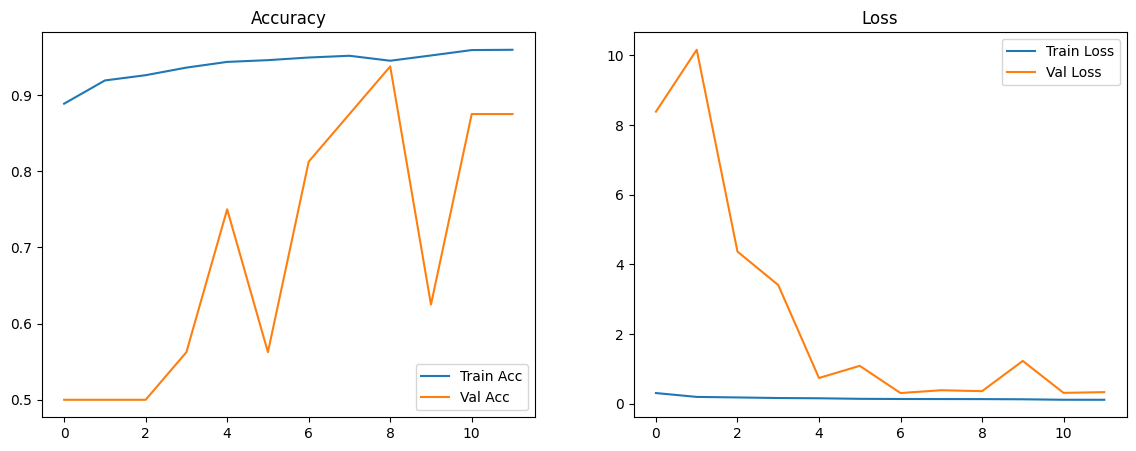

In [ ]:
# Training plots
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()


3.9 : Evaluate on Test Set

20/20 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step
[[213  21]
 [ 58 332]]
              precision    recall  f1-score   support

      NORMAL       0.79      0.91      0.84       234
   PNEUMONIA       0.94      0.85      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.88      0.87       624
weighted avg       0.88      0.87      0.87       624



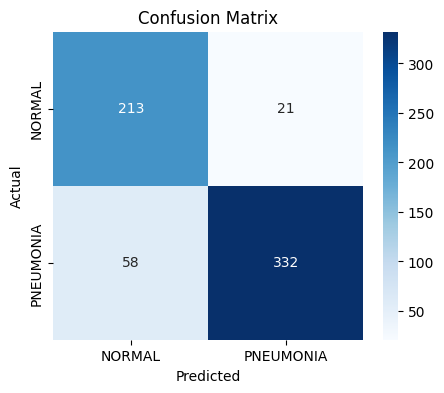

In [ ]:
# Test evaluation
test_generator.reset()

pred_prob = model.predict(test_generator)
pred = (pred_prob > 0.5).astype(int).ravel()

y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, pred)
print(cm)

# Classification Report
cr = classification_report(
    y_true, pred,
    target_names=list(test_generator.class_indices.keys())
)
print(cr)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


3.10 : Saving Report

In [ ]:
# Save reports
report_dir = "/content/drive/MyDrive/chest_xray_report/"
os.makedirs(report_dir, exist_ok=True)

# Save classification report
with open(report_dir + "medium_cnn_classification_report.txt", "w") as f:
    f.write(cr)

# Save confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.savefig(report_dir + "medium_cnn_confusion_matrix.png")
plt.close()
